In [113]:
from sktime.regression.distance_based import KNeighborsTimeSeriesRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.inspection import permutation_importance
from sklearn.impute import KNNImputer
from sklearn.model_selection import TimeSeriesSplit
from scipy import interpolate
from statsmodels.tsa.stattools import adfuller
from sktime.split import temporal_train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
names = ["Brazil", "Colombia", "Vietnam", "Indonesia", "Honduras"]
data_dict = {}  

for name in names:
    input_file = f"../clean_data/{name}_weather_cleaned.csv" 
    data_dict[name] = pd.read_csv(input_file)  

main_df = pd.read_csv("../clean_data/main_df_clean.csv")



Date = main_df["Date"]
y= main_df["Coffee"]
main_df = main_df.drop(["Date", "Coffee"], axis = 1)

main_df_diff = main_df.diff()

main_df_diff = main_df_diff.dropna()
main_df_diff

,brl Exchange Rate,vnd Exchange Rate,hnl Exchange Rate,idr Exchange Rate,Milk,Sugar,Tea,cop Exchange Rate,Negative_News_Ratio,close,...,Honduras_wind_speed_10m_max_hon,Honduras_wind_gusts_10m_max_hon,Honduras_et0_fao_evapotranspiration_hon,Indonesia_temperature_2m_mean_in,Indonesia_daylight_duration_in,Indonesia_sunshine_duration_in,Indonesia_precipitation_sum_in,Indonesia_wind_speed_10m_max_in,Indonesia_wind_gusts_10m_max_in,Indonesia_et0_fao_evapotranspiration_in
1,0.000004,0.000000,0.0000,5.020000,0.004653,0.004500,-0.188876,11.64,0.000892,13.80,...,0.662664,-0.328479,0.552624,0.186313,-0.072102,0.758565,2.114401,-3.283790,-8.396129,0.106860
2,0.000006,0.000000,2.0000,10.480000,-0.000649,0.006600,-0.084776,11.68,0.000931,-1.65,...,1.041422,3.998157,0.341810,0.267115,-0.090199,0.574258,0.579148,-0.481123,0.127742,0.295299
3,0.000004,0.000000,0.0000,5.700000,0.003213,-0.000700,0.010024,11.22,0.000974,1.59,...,-0.061251,-0.483871,0.657260,0.525301,-0.089476,-0.055913,-3.274624,-1.339813,-4.267742,-0.047617
4,0.000002,84.101337,0.2000,5.350000,0.011317,-0.006200,-0.035335,11.37,0.001019,0.32,...,-1.228709,-1.583226,-0.028896,0.075910,-0.070560,-0.066730,-0.554409,0.492929,2.049677,-0.183136
5,0.000002,489.316870,0.0000,9.600000,-0.003960,-0.016500,-0.025084,11.32,0.001068,-8.45,...,-1.889366,-0.096774,-0.699132,-0.267923,-0.033875,0.064547,-2.242258,0.851568,0.434323,-0.097676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,0.153073,-1.240000,0.1146,-67.736063,0.003389,0.001822,0.030359,-17.76,-0.000011,2.40,...,0.109079,-0.853936,0.403202,0.691760,0.017232,1.416218,-2.794839,1.474067,3.466839,0.720212
415,0.010566,-5.710000,0.0244,-468.471008,0.002571,-0.009322,0.103634,26.18,-0.000017,14.85,...,0.569049,1.614194,0.400077,1.587702,0.060400,0.063047,-2.348387,2.078232,5.446451,0.734200
416,-0.011047,-82.310000,-0.0445,-451.931818,0.006766,0.022052,0.105838,128.88,-0.000027,26.20,...,-4.390441,-8.320258,-0.302391,-0.761545,0.083536,-0.844577,5.059892,-1.574848,-6.021290,-0.520255
417,0.082542,28.980000,0.1280,200.097826,-0.012874,0.017305,-0.082758,65.90,-0.000053,-24.35,...,5.077178,9.992516,-0.700346,-0.129516,0.092305,0.710848,-2.250215,-0.791097,-1.747742,0.251557


In [145]:

adfuller(y)
# Fail to reject null, so there is evidence for unit root(non-stationarity)
y_diff = y.diff()
y_diff = y_diff.dropna()
adfuller(y_diff)
# Reject null, so evidence for stationarity
print(y_diff.index)
y_diff


Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       409, 410, 411, 412, 413, 414, 415, 416, 417, 418],
      dtype='int64', length=418)


1      0.081800
2      0.099500
3     -0.002300
4     -0.017100
5     -0.037600
         ...   
414    0.086937
415    0.043390
416    0.173227
417   -0.019831
418    0.281755
Name: Coffee, Length: 418, dtype: float64

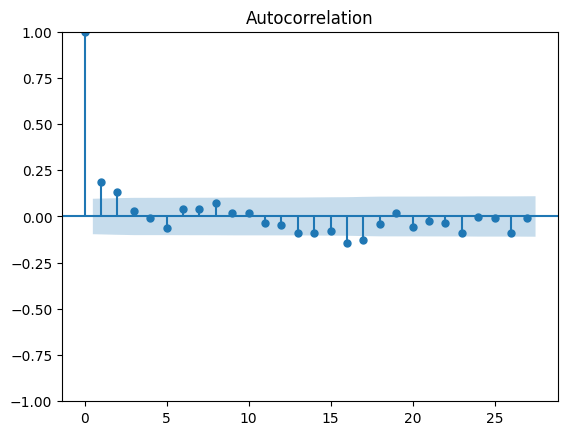

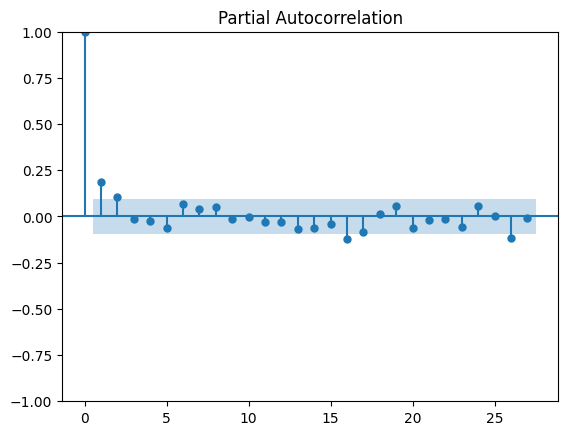

In [146]:
plot_acf(y_diff)
plot_pacf(y_diff)
plt.show()

In [ ]:

y_lag = y_diff.shift(1).dropna().rename("Coffee_Lag_1")
y_lag_2 = y_lag.shift(1).dropna().rename("Coffee_Lag_2")
y_lag_3 = y_lag_2.shift(1).dropna().rename("Coffee_Lag_3")


X = pd.concat([y_lag,y_lag_2, y_lag_3, main_df_diff], axis=1).dropna()
X

,Coffee_Lag_1,Coffee_Lag_2,Coffee_Lag_3,brl Exchange Rate,vnd Exchange Rate,hnl Exchange Rate,idr Exchange Rate,Milk,Sugar,Tea,...,Honduras_wind_speed_10m_max_hon,Honduras_wind_gusts_10m_max_hon,Honduras_et0_fao_evapotranspiration_hon,Indonesia_temperature_2m_mean_in,Indonesia_daylight_duration_in,Indonesia_sunshine_duration_in,Indonesia_precipitation_sum_in,Indonesia_wind_speed_10m_max_in,Indonesia_wind_gusts_10m_max_in,Indonesia_et0_fao_evapotranspiration_in
7,-0.017800,-0.037600,-0.017100,0.000002,0.000000,0.0000,7.960000,0.006048,-0.010700,-0.069128,...,-0.022829,2.601290,-0.279731,0.251815,0.059568,-0.182142,2.193548,-0.051077,0.116129,0.310563
8,0.079400,-0.017800,-0.037600,0.000002,1529.115217,0.0000,5.430000,0.006110,0.000900,0.048534,...,-1.101774,-4.972257,-0.085092,0.445699,0.083161,0.618301,-2.086559,1.712644,5.204129,0.444131
9,0.005000,0.079400,-0.017800,0.000008,0.000000,1.3000,5.500000,-0.004442,-0.016300,0.158531,...,1.191787,1.093548,-0.749462,0.131585,0.092318,-0.571195,2.280107,-1.113392,-1.824774,-0.138590
10,-0.035100,0.005000,0.079400,0.000012,191.139402,-0.1000,-5.370000,0.004348,0.006700,0.038102,...,0.091767,3.682452,-1.112019,-0.334850,0.083923,-0.558151,1.409893,-1.945762,-4.679226,-0.270693
11,-0.065700,-0.035100,0.005000,0.000014,191.139402,-0.1000,31.200000,-0.005450,-0.003200,-0.039236,...,-0.378418,-2.405032,0.374118,-1.082623,0.044159,-1.271945,4.706237,4.150729,7.245678,-0.844268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,0.160624,-0.075238,0.309530,0.153073,-1.240000,0.1146,-67.736063,0.003389,0.001822,0.030359,...,0.109079,-0.853936,0.403202,0.691760,0.017232,1.416218,-2.794839,1.474067,3.466839,0.720212
415,0.086937,0.160624,-0.075238,0.010566,-5.710000,0.0244,-468.471008,0.002571,-0.009322,0.103634,...,0.569049,1.614194,0.400077,1.587702,0.060400,0.063047,-2.348387,2.078232,5.446451,0.734200
416,0.043390,0.086937,0.160624,-0.011047,-82.310000,-0.0445,-451.931818,0.006766,0.022052,0.105838,...,-4.390441,-8.320258,-0.302391,-0.761545,0.083536,-0.844577,5.059892,-1.574848,-6.021290,-0.520255
417,0.173227,0.043390,0.086937,0.082542,28.980000,0.1280,200.097826,-0.012874,0.017305,-0.082758,...,5.077178,9.992516,-0.700346,-0.129516,0.092305,0.710848,-2.250215,-0.791097,-1.747742,0.251557


In [ ]:
X, y_diff = X.align(y_diff, join='inner', axis=0)
mi_scores = mutual_info_regression(X, y_diff)

mi_scores_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

non_zero_mi_scores = mi_scores_series[mi_scores_series > 0] 



X_filtered = X[non_zero_mi_scores.index]
X_filtered


,close,Vietnam_precipitation_sum_vn,Sugar,Indonesia_et0_fao_evapotranspiration_in,Tea,Honduras_wind_speed_10m_max_hon,Colombia_wind_gusts_10m_max_col,idr Exchange Rate,Coffee_Lag_1,Indonesia_sunshine_duration_in,Colombia_wind_speed_10m_max_col,Vietnam_temperature_2m_mean_vn,Indonesia_daylight_duration_in,Coffee_Lag_2,Honduras_wind_gusts_10m_max_hon,Indonesia_wind_gusts_10m_max_in,Vietnam_sunshine_duration_vn,brl Exchange Rate
4,0.32,3.560431,-0.006200,-0.183136,-0.035335,-1.228709,-1.367613,5.350000,-0.002300,-0.066730,-0.130266,-0.559971,-0.070560,0.099500,-1.583226,2.049677,-1.321257,0.000002
5,-8.45,11.166237,-0.016500,-0.097676,-0.025084,-1.889366,-1.824387,9.600000,-0.017100,0.064547,-0.288586,-1.329405,-0.033875,-0.002300,-0.096774,0.434323,-1.882345,0.000002
6,8.20,-13.343656,-0.009700,0.083558,0.037648,0.807290,1.116000,5.960000,-0.037600,0.375086,0.249388,0.148692,0.015976,-0.017100,-2.249032,-0.376258,1.964246,0.000004
7,9.05,4.145161,-0.010700,0.310563,-0.069128,-0.022829,2.694193,7.960000,-0.017800,-0.182142,0.595840,-0.397446,0.059568,-0.037600,2.601290,0.116129,-1.896279,0.000002
8,-9.85,-3.401505,0.000900,0.444131,0.048534,-1.101774,0.257806,5.430000,0.079400,0.618301,0.418219,0.158130,0.083161,-0.017800,-4.972257,5.204129,0.888048,0.000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,2.40,4.225484,0.001822,0.720212,0.030359,0.109079,1.033548,-67.736063,0.160624,1.416218,1.330328,-1.764219,0.017232,-0.075238,-0.853936,3.466839,-1.983999,0.153073
415,14.85,-3.319355,-0.009322,0.734200,0.103634,0.569049,0.267097,-468.471008,0.086937,0.063047,-0.317732,1.151075,0.060400,0.160624,1.614194,5.446451,2.894445,0.010566
416,26.20,1.957204,0.022052,-0.520255,0.105838,-4.390441,2.983355,-451.931818,0.043390,-0.844577,1.554439,-0.993801,0.083536,0.086937,-8.320258,-6.021290,-3.160654,-0.011047
417,-24.35,-3.370108,0.017305,0.251557,-0.082758,5.077178,-2.797548,200.097826,0.173227,0.710848,-1.541885,-0.481938,0.092305,0.043390,9.992516,-1.747742,1.118094,0.082542


In [112]:
X_train, X_test, y_train, y_test = temporal_train_test_split(X_filtered, y_diff, test_size=0.2)
y_train = y_train.ravel() 
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")


Train size: 328, Test size: 82


C:\Users\Admin\AppData\Local\Temp\ipykernel_25624\3459425444.py:2: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_train = y_train.ravel()


In [149]:
scaler = StandardScaler()
X_scaled = scaler.fit(X_train)
X_train_trans = scaler.transform(X_train)
X_test_trans = scaler.transform(X_test)




In [150]:
knn_regressor = KNeighborsTimeSeriesRegressor(n_neighbors=3)

knn_regressor.fit(X_train_trans , y_train)
y_hat_train = knn_regressor.predict(X_train_trans)
y_hat_test = knn_regressor.predict(X_test_trans)


In [151]:

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print(train_mse)
print(test_mse)



0.007471346017204745
0.016417852564204218


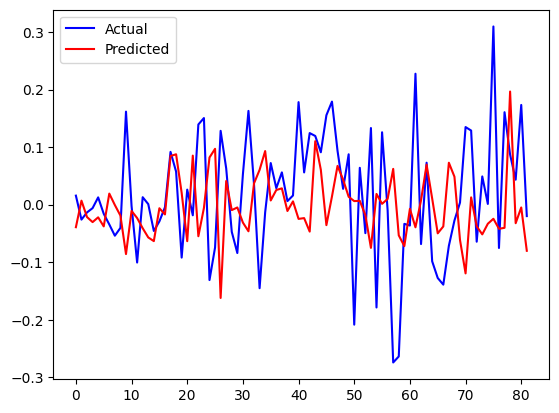

In [152]:
plt.plot(np.array(y_test), label='Actual', color = "blue")
plt.plot(y_hat_test, label='Predicted', color = "red")
plt.legend()